# Time Series Tools

In [3]:
import pandas as pd
import numpy as np
import requests
import datetime
import math
import time

import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

import seaborn as sns

In [4]:
bdata = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20150101&end="+time.strftime("%Y%m%d"))[0]
bdata = bdata.assign(Date=pd.to_datetime(bdata['Date']))
bdata['Volume'] = bdata['Volume'].astype('int64')
bdata = bdata.sort_values(by='Date')
bdata = bdata.reset_index(drop=True)
bdata.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2015-01-01,320.44,320.44,314.00,314.25,8036550,4380820000
1,2015-01-02,314.08,315.84,313.56,315.03,7860650,4295210000
2,2015-01-03,314.85,315.15,281.08,281.08,33054400,4307010000
3,2015-01-04,281.15,287.23,257.61,264.19,55629100,3847150000
4,2015-01-05,265.08,278.34,265.08,274.47,43962800,3628490000


Closing Price from 1/1/2015 until date of query, 5/6/2018

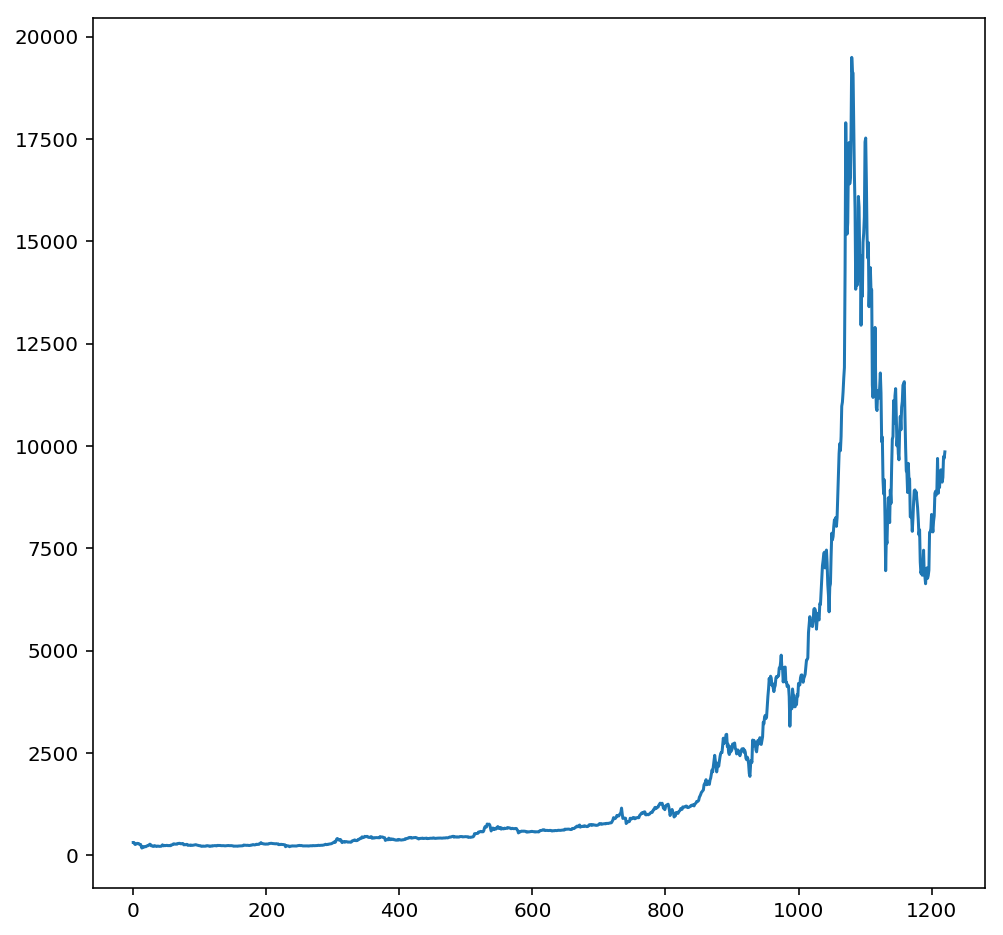

In [5]:
bdata['Close'].plot(figsize=(8,8))

Calculated difference from current to previous day

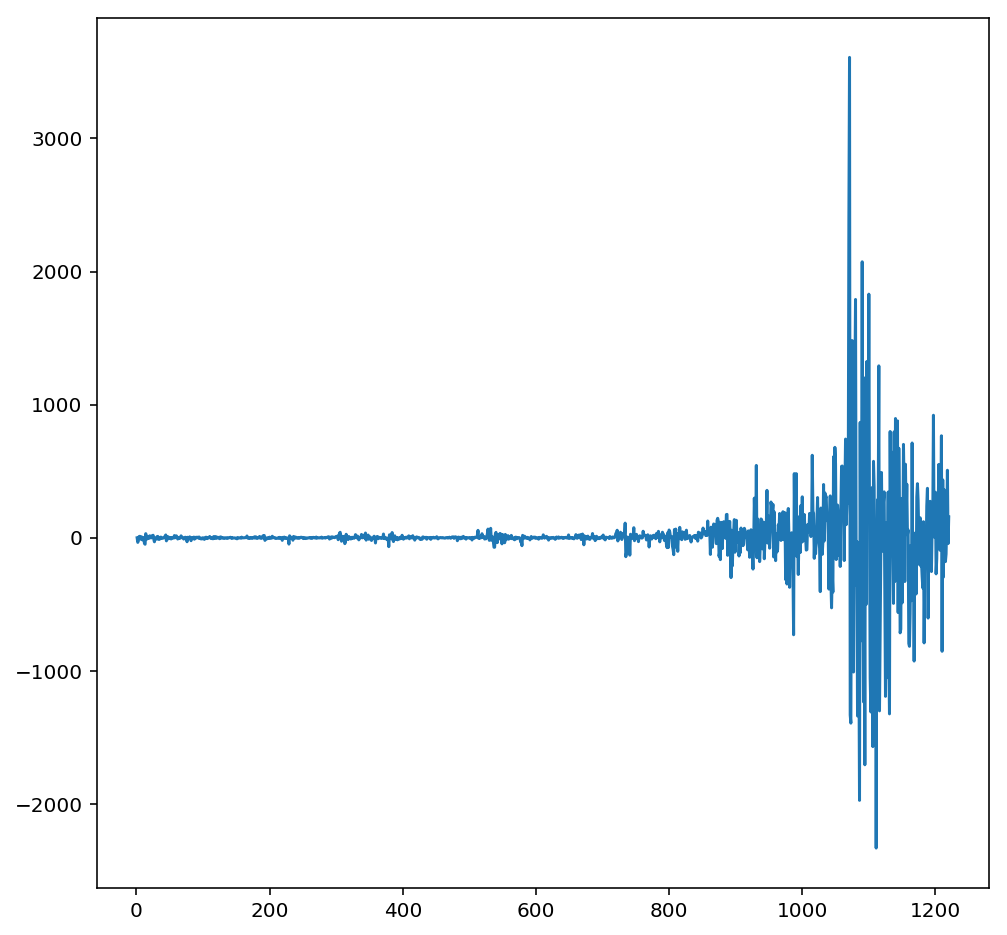

In [6]:
bdata['First Difference'] = bdata['Close'] - bdata['Close'].shift()
bdata['First Difference'].plot(figsize=(8,8))

Natural log transformation of original graph exposes proportional differences

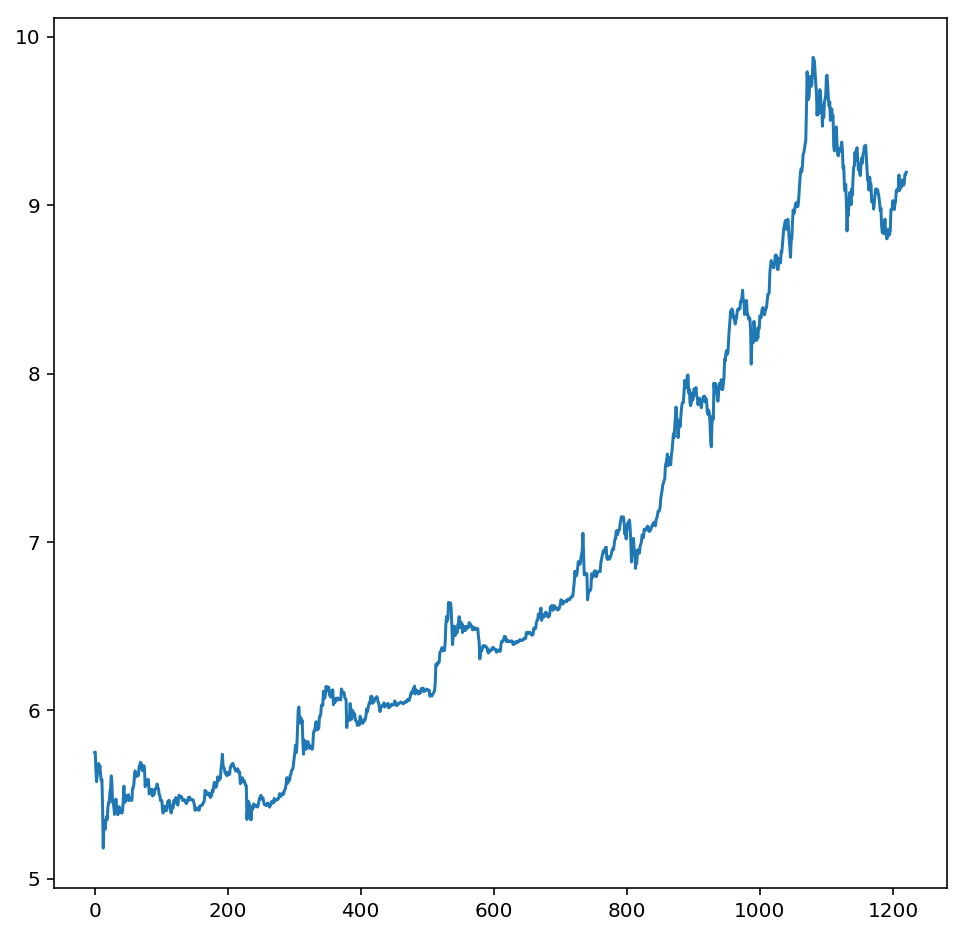

In [7]:
bdata['Natural Log'] = bdata['Close'].apply(lambda x: np.log(x))
bdata['Natural Log'].plot(figsize=(8,8))

The original variance makes it extremely hard to see any changes in comparison, since the spike in prices makes it hard to compare other values

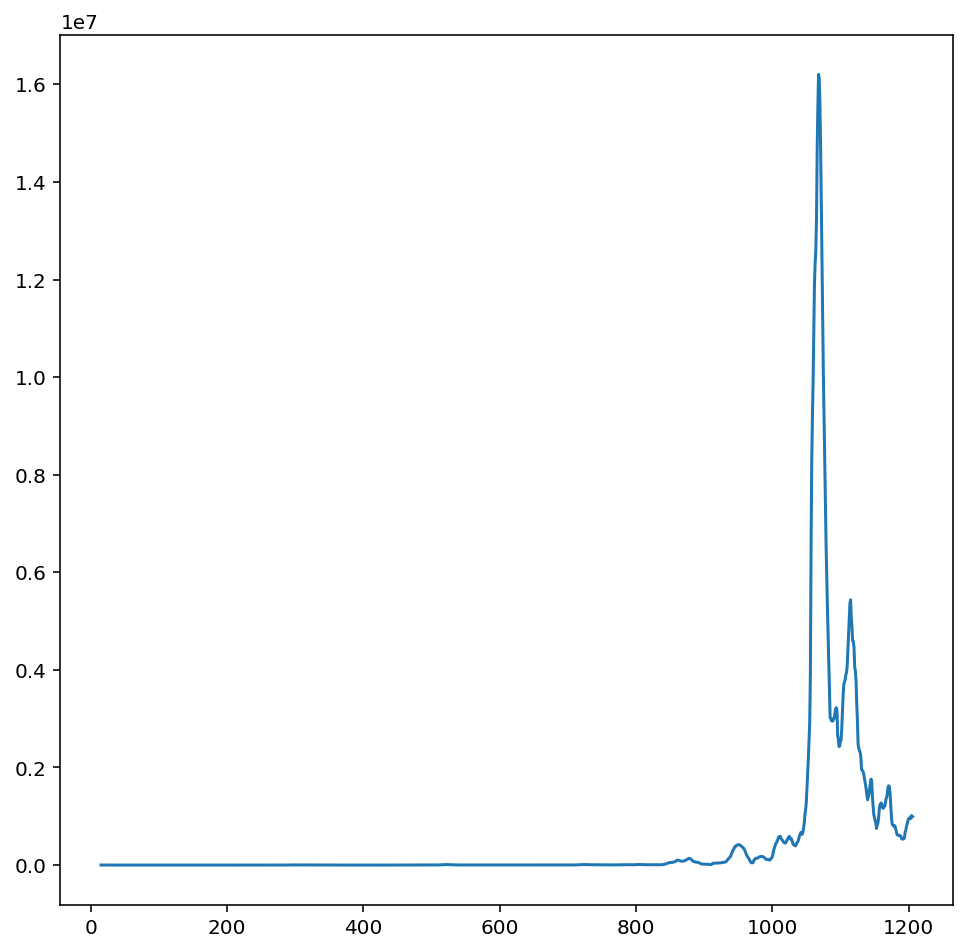

In [8]:
bdata['Original Variance'] = bdata['Close'].rolling(window=30, center=True).var()
bdata['Original Variance'].plot(figsize=(8,8))

Using a log variance, we can see all changes exposed.
However, we are now in a period where Bitcoin has been exposed to a larger population.  Do old trends still apply to the current market? I hope to test this with models that use different cutoff dates for the data.

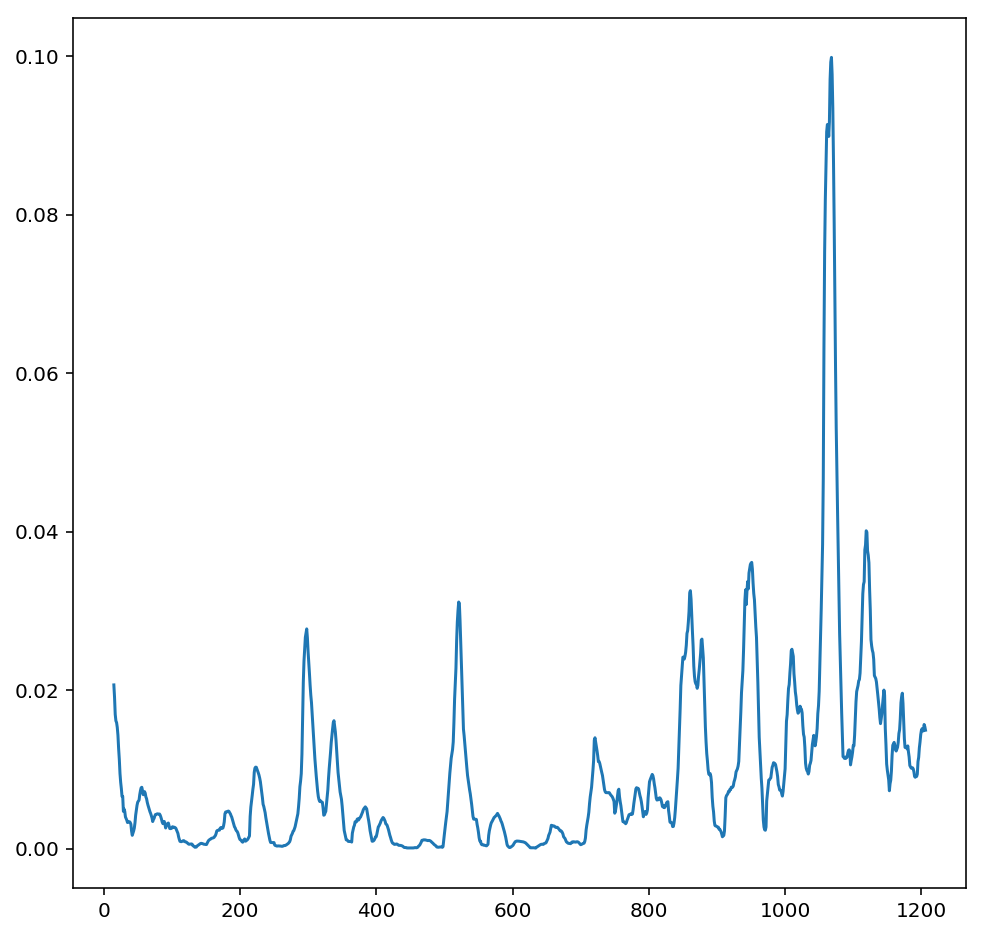

In [9]:
bdata['Log Variance'] =  bdata['Natural Log'].rolling(window=30, center=True).var()
bdata['Log Variance'].plot(figsize=(8,8))

Getting the logged first difference makes the data stationary ( a requirement for good time series analysis), and makes the changes in price much easier to see

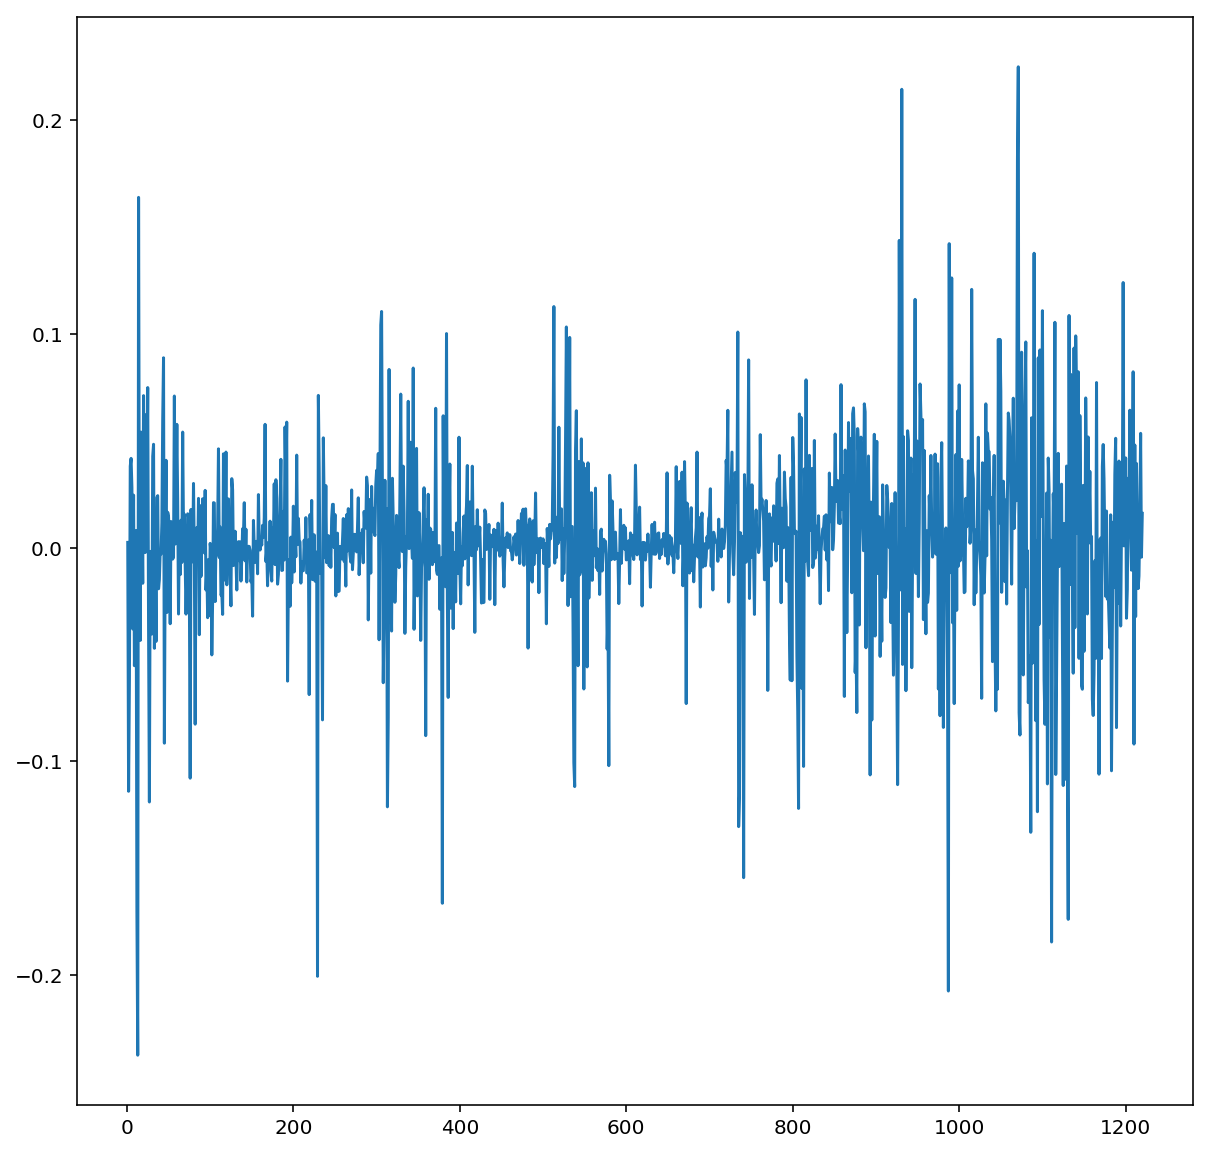

In [10]:
bdata['Logged First Difference'] = bdata['Natural Log'] - bdata['Natural Log'].shift()
bdata['Logged First Difference'].plot(figsize=(10,10))

Creating Lag Variables

In [11]:
# Daily Lag
bdata['Lag 1'] = bdata['Logged First Difference'].shift()
# Weekly Lag
bdata['Lag 5'] = bdata['Logged First Difference'].shift(5)

/Users/William/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


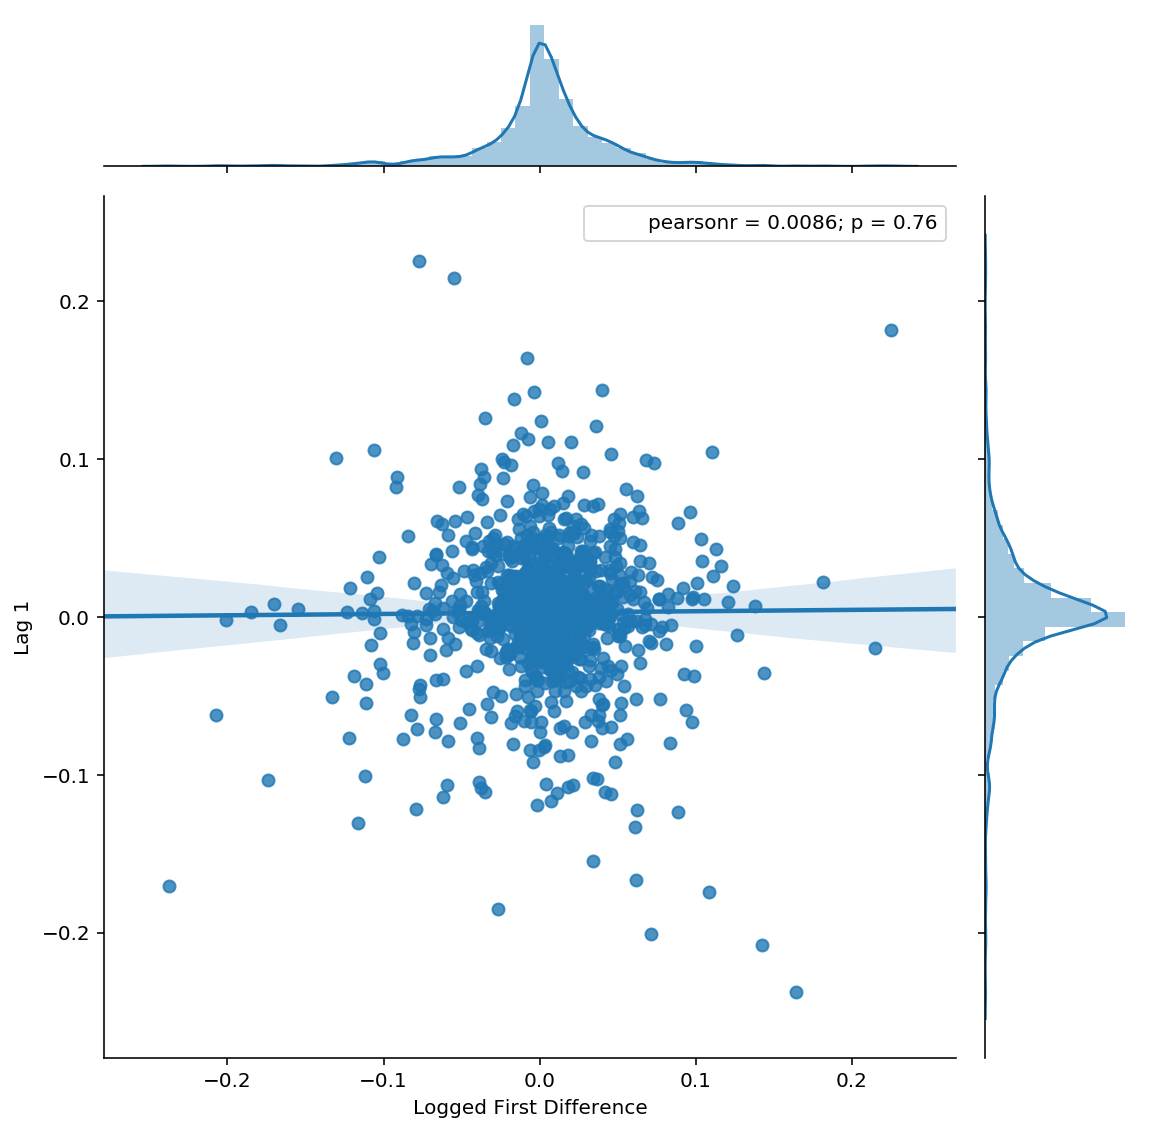

In [12]:
sns.jointplot('Logged First Difference', 'Lag 1', bdata, kind='reg', size=8)

/Users/William/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


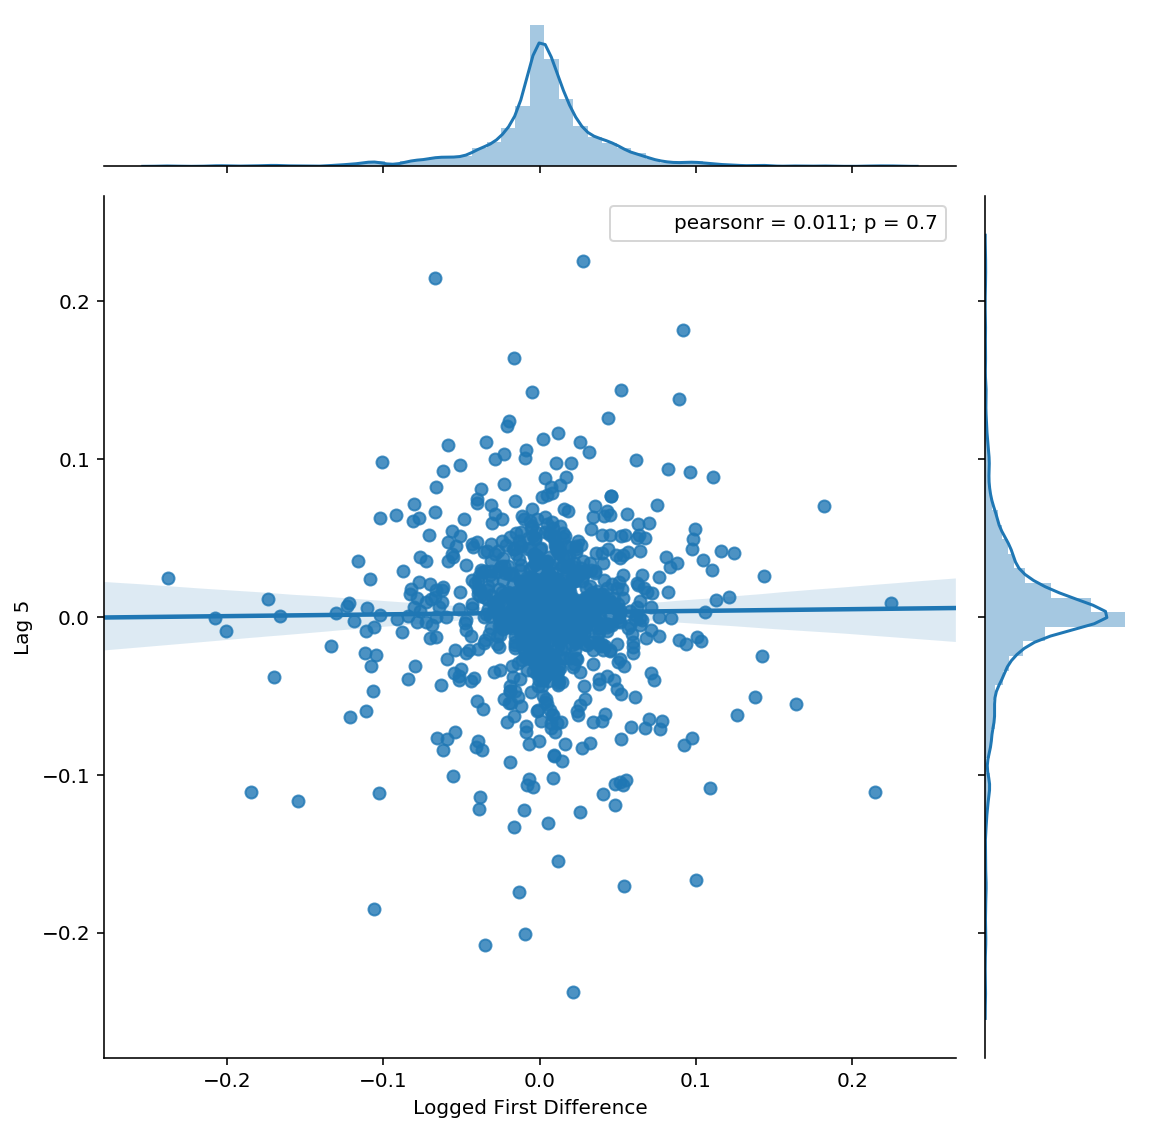

In [13]:
sns.jointplot('Logged First Difference', 'Lag 5', bdata, kind='reg', size=8)

The joint plots show zero-centered and a somewhat distribution, so therefore there is not much correlation between daily or weekly prices to the current price.

In [15]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
lag_correlations = acf(bdata['Logged First Difference'].iloc[1:])  
lag_partial_correlations = pacf(bdata['Logged First Difference'].iloc[1:])

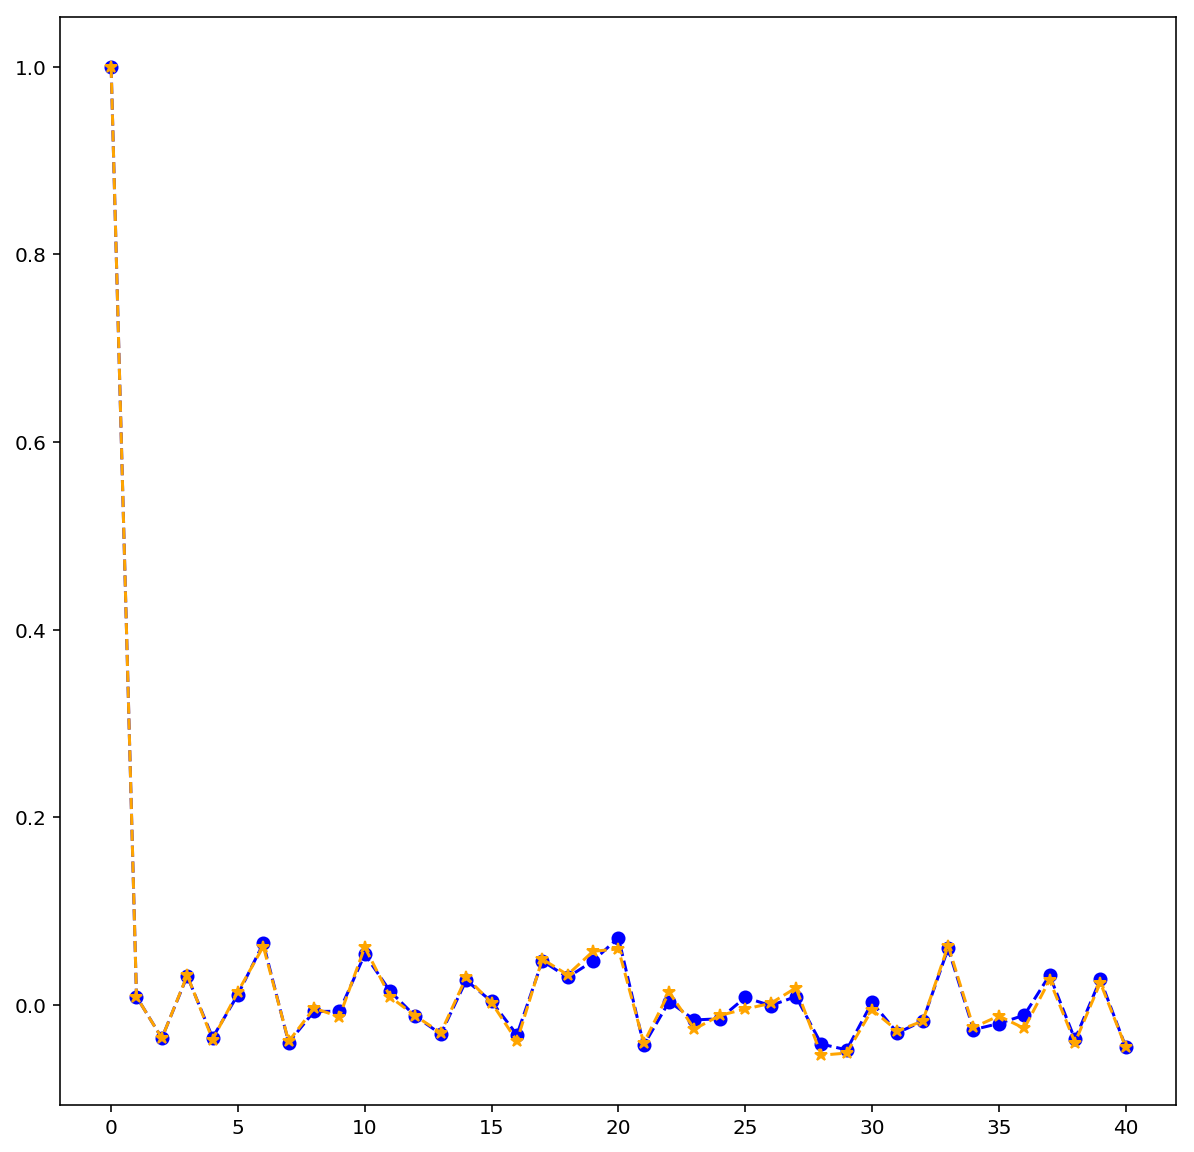

In [16]:
fig, ax = plt.subplots(figsize=(10,10))  
handles, labels = ax.get_legend_handles_labels()
ax.plot( lag_correlations, marker='o', linestyle='--', c='blue' )
ax.plot( lag_partial_correlations,  marker='*', linestyle='--', c='orange' )

Here we can see that past prices of 1 to 40 days ago do not have a very good correlation to the current price

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
bdata = bdata.set_index('Date')
decomposition = seasonal_decompose( bdata['Natural Log'], model='additive', freq=30 )

<Figure size 576x576 with 0 Axes>

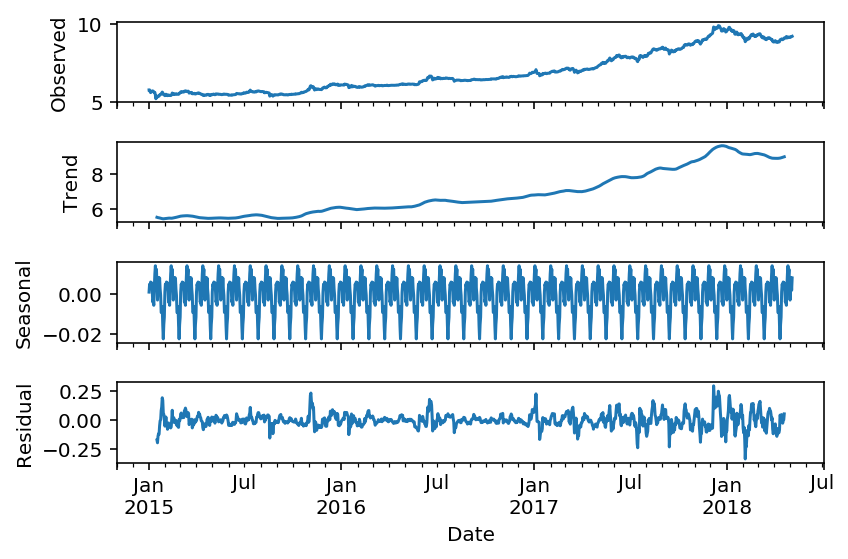

In [24]:
fig = plt.figure(figsize=(8,8))  
fig = decomposition.plot()

<Figure size 576x576 with 0 Axes>

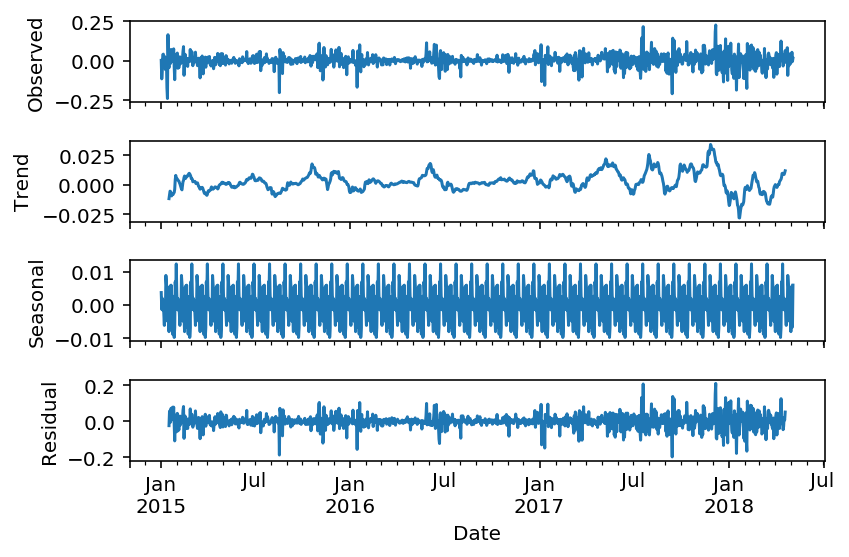

In [27]:
decomposition = seasonal_decompose( bdata['Logged First Difference'].dropna(), model='additive', freq=30 )
fig = plt.figure(figsize=(8,8))  
fig = decomposition.plot()

For difference in prices and the price itself, there are no clear cycles or trends

In [33]:
import statsmodels.api as sa

## ARIMA

ARIMA(1,0,0) = first-order autoregressive model: if the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant. 

/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


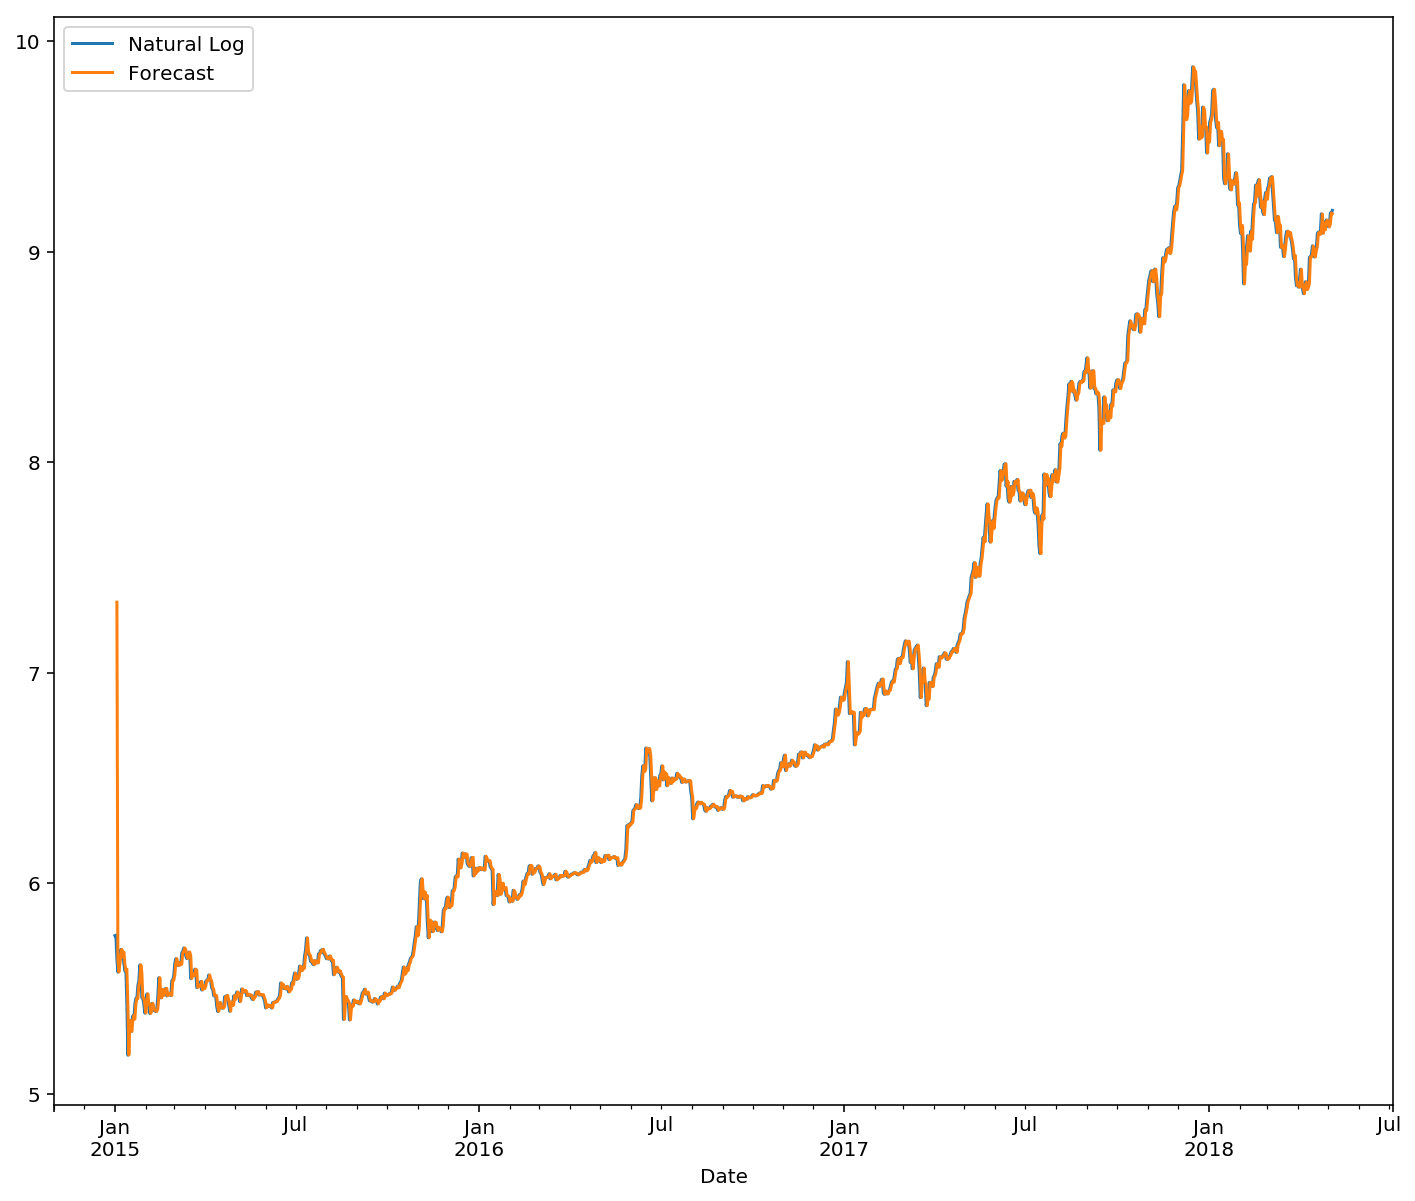

In [41]:
model = sa.tsa.ARIMA(bdata['Natural Log'].dropna().iloc[2:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
bdata['Forecast'] = results.fittedvalues  
bdata[['Natural Log', 'Forecast']].plot(figsize=(12, 10))

In a second-order autoregressive model (ARIMA(2,0,0)), there would be a Yt-2  term on the right as well, and so on.  Depending on the signs and magnitudes of the coefficients, an ARIMA(2,0,0) model could describe a system whose mean reversion takes place in a sinusoidally oscillating fashion, like the motion of a mass on a spring that is subjected to random shocks.

/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


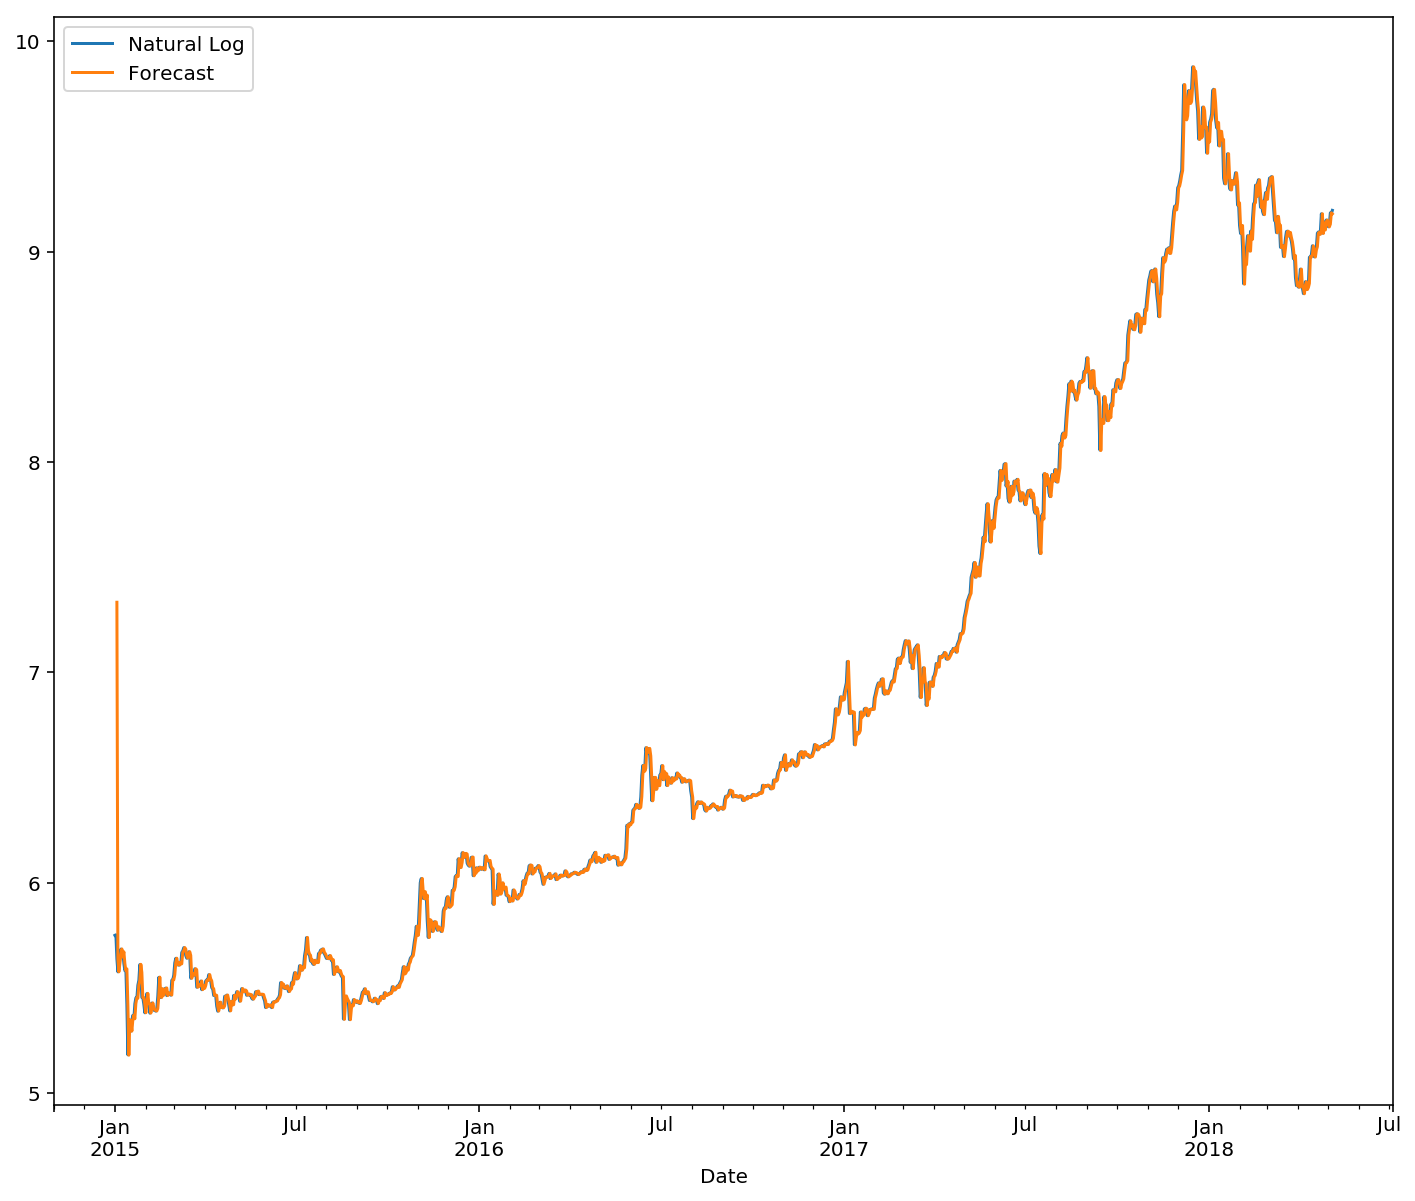

In [42]:
model = sa.tsa.ARIMA(bdata['Natural Log'].dropna().iloc[2:], order=(2, 0, 0))  
results = model.fit(disp=-1)  
bdata['Forecast'] = results.fittedvalues  
bdata[['Natural Log', 'Forecast']].plot(figsize=(12, 10))

If the errors of a random walk model are autocorrelated, perhaps the problem can be fixed by adding one lag of the dependent variable to the prediction equation--i.e., by regressing the first difference of Y on itself lagged by one period. 

/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/William/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


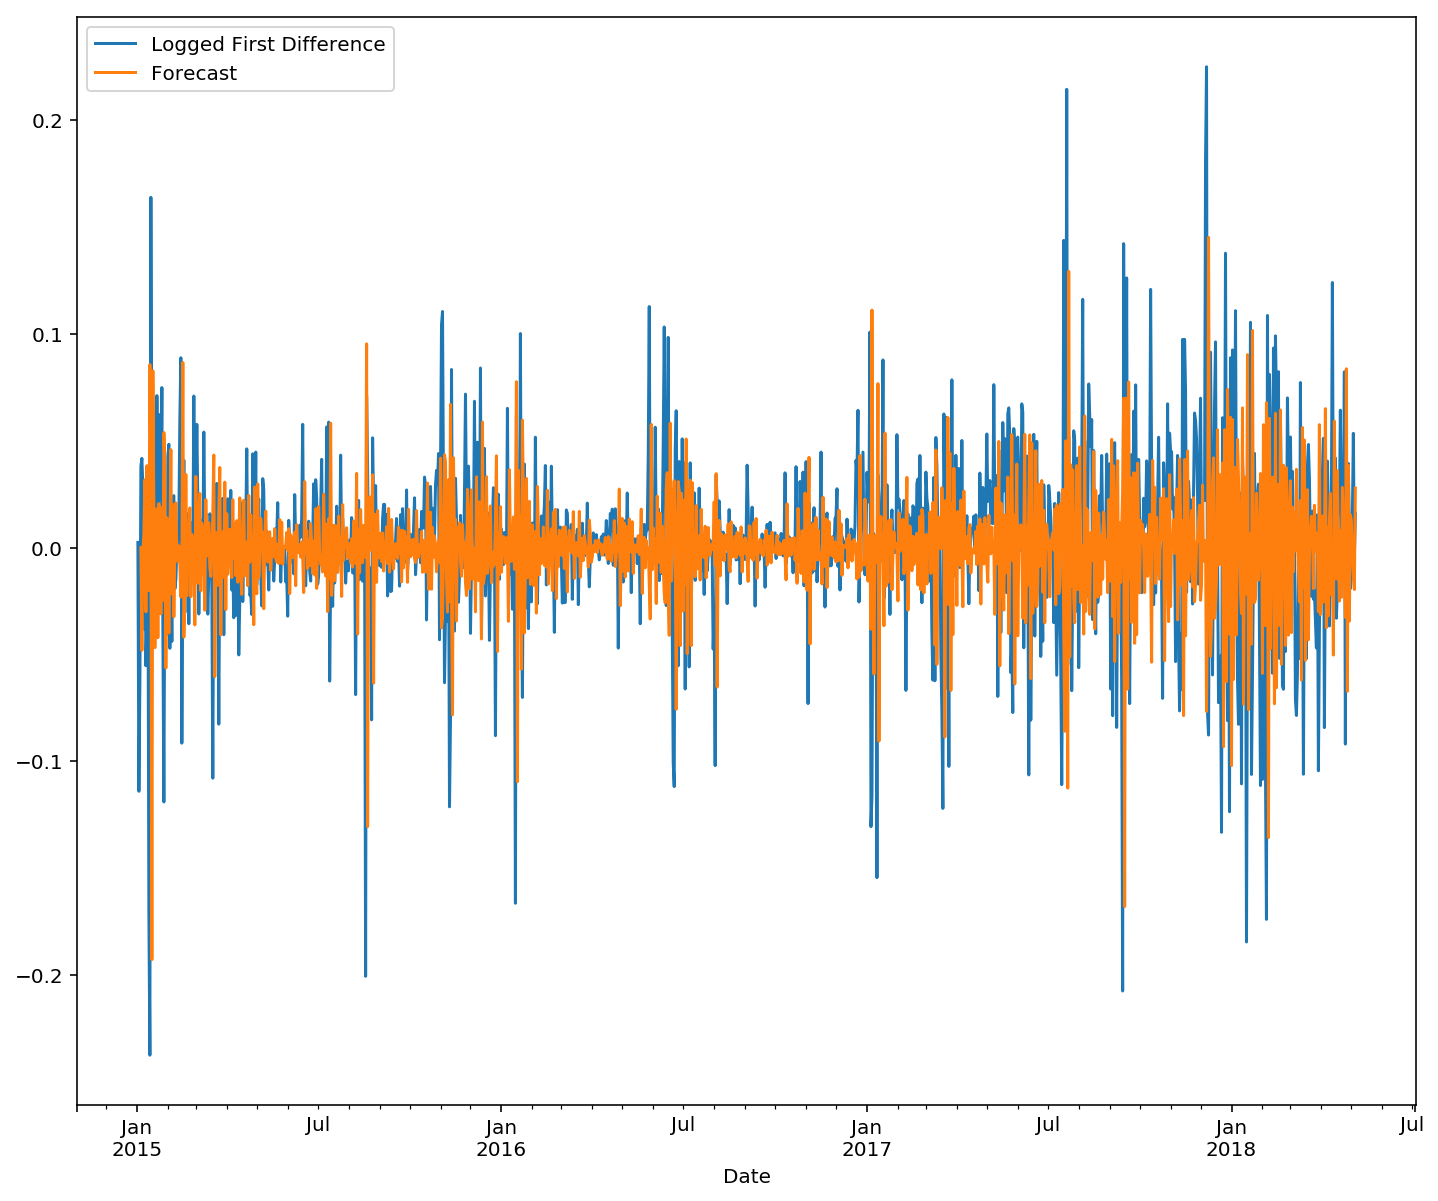

In [45]:
model = sa.tsa.ARIMA(bdata['Logged First Difference'].dropna().iloc[2:], order=(1, 1, 0))  
results = model.fit(disp=-1)  
bdata['Forecast'] = results.fittedvalues  
bdata[['Logged First Difference', 'Forecast']].plot(figsize=(12, 10))